In [1]:
import pandas as pd
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from IPython.display import Audio

#### Ouverture du csv des annotations, changement des colonnes

In [2]:
directory = './challenge-m2-sid/'
annot = pd.read_csv(directory+'annotations_challenge_sid.csv', sep="\t", index_col=0, header=0).replace(-1,np.nan)
noteurs = annot.columns[1:]

annot['doc']      = ["_".join(e.split("_")[0:2]) for e in annot["code_doc"]]
annot['audio']    = [int(e.split("_")[2][0])     for e in annot["code_doc"]]
annot['video']    = [int(e.split("_")[2][1])     for e in annot["code_doc"]]
annot['texte']    = [int(e.split("_")[2][2])     for e in annot["code_doc"]]
annot['isGraded'] = [int(e.split("_")[3])        for e in annot["code_doc"]]

annot = annot.drop("code_doc", axis=1)
annot.head()

,il08_09,vg04_05,fd03_04,la09_10,cg13_14,mb00_12,doc,audio,video,texte,isGraded
1,NaN,NaN,NaN,NaN,NaN,NaN,119_8,1,0,0,0
2,NaN,NaN,NaN,NaN,NaN,NaN,119_8,1,1,0,0
3,NaN,NaN,NaN,NaN,NaN,NaN,119_8,1,1,1,0
4,NaN,NaN,NaN,NaN,NaN,NaN,119_8,1,0,1,0
5,NaN,NaN,NaN,NaN,NaN,NaN,119_8,0,0,1,0


#### Selection des audio notés et calcul de la moyenne

In [3]:
audio_only = annot[(annot['isGraded'] == 1) &
                   (annot['audio'] == 1) &
                   (annot['video'] == 0) &
                   (annot['texte'] == 0)].copy()

audio = annot[(annot['isGraded'] == 1) & 
              (annot['audio'] == 1)
             ].copy()

audio['moyenne']      = audio[noteurs].apply(np.nanmean, axis=1)
audio_only['moyenne'] = audio_only[noteurs].apply(np.nanmean, axis=1)

print("audio :",      len(set(audio['doc'])))
print("audio_only :", len(set(audio_only['doc'])))

audio_only[['doc','moyenne']].groupby(['doc']).agg(['count','mean']).head(7)

audio : 55
audio_only : 33


moyenne      
        count  mean
doc                
100_1       1  47.5
107_7       1  76.0
108_3       1  66.0
128_5       1  81.0
13_2        1  62.5
147_1       1  64.0
148_4       1  13.0

#### liste des fichiers audio annotés

In [4]:
listeWavNote = sorted(list(set([e + "_mono.wav" for e in audio['doc']])))
listeWavNote[0:10]

['100_1_mono.wav',
 '107_7_mono.wav',
 '108_3_mono.wav',
 '116_15_mono.wav',
 '128_5_mono.wav',
 '129_5_mono.wav',
 '12_13_mono.wav',
 '13_2_mono.wav',
 '147_1_mono.wav',
 '148_4_mono.wav']

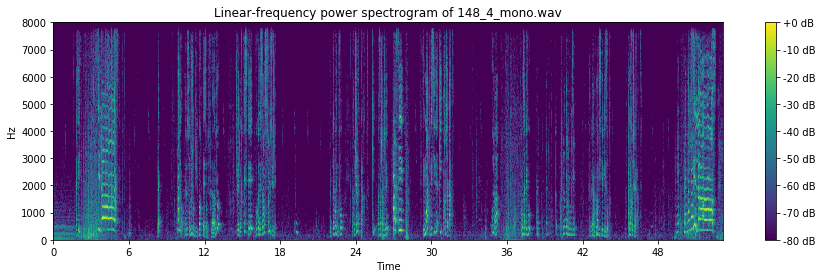

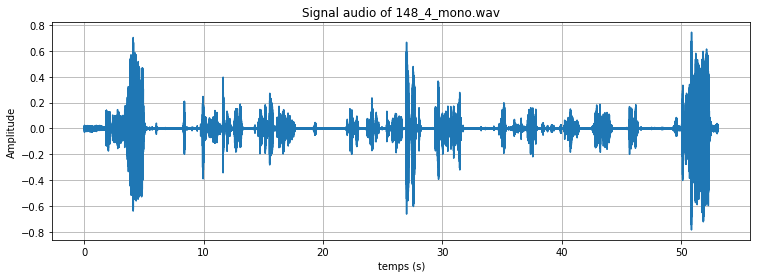

In [5]:
selected_wav = listeWavNote[9]
signal, fe = librosa.load(directory + 'corpus/audio/' + selected_wav, sr=16000, mono=True)

# Affichage d'un spectrogramme
sp = np.abs(librosa.stft(signal, n_fft=512, hop_length=256, window=np.hanning(512 + 2)[1:-1]))
sp = 20.0 * np.log10(np.maximum(sp, np.max(sp) / 1e6))
sp = sp - np.mean(sp)
sp = sp - np.max(sp)
plt.figure(figsize=(15,4))
librosa.display.specshow(sp, sr=fe, hop_length=256, y_axis='linear', x_axis='time', cmap='viridis', vmin=-80.0, vmax=0)
plt.colorbar(format='%+2.0f dB')
plt.title('Linear-frequency power spectrogram of ' + selected_wav)
plt.show()

# Affichage du signal
plt.figure(figsize=(12.5,4))
plt.plot(np.arange(len(signal))/fe,signal)
plt.xlabel('temps (s)')
plt.ylabel('Amplitude')
plt.title('Signal audio of ' + selected_wav)
plt.grid(True)
plt.show()

# lecture du fichier
Audio(data=signal, rate=fe)

### Sous échantillon

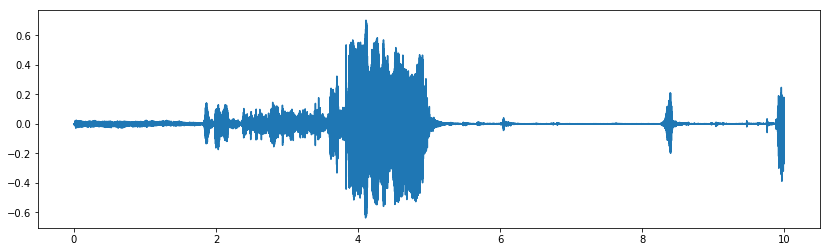

In [6]:
debut, fin = 0, 10
subSignal = signal[debut*fe : fin*fe]
plt.figure(figsize=(14,4))
plt.plot(np.arange(len(subSignal))/fe, subSignal)
plt.show()

Audio(data=signal[0*fe : 10*fe], rate=fe)

### Librairies : Pybk, webTRC, SNR, énergie, ZCR, MFCC
score de reconnaissance de quelque chose par mfcc (associé au texte ?)  
nombre de locuteurs (et en même temps)  
quantité de bruit  
ligth gradient boosting (si pb de corrélation)  
accent ?  
SNR  
lium speaker derivation (java) -> nombre de locuteur, (~segmentation parole/non parole)

#### Speech recognition API (too long and limited)

In [8]:
import speech_recognition as sr  
r  = sr.Recognizer()
signal, fe = librosa.load(directory + 'corpus/audio/' + selected_wav, sr=16000, mono=True)
audio_source = sr.AudioData(signal, fe, 1)
text = r.recognize_google(audio_data=audio_source)
text

'play'

#### speech detection using webrtcvad (cool)

In [9]:
def get_speech_intervals(bin_signal, fe=16000, agg=0, affichage=False):
    signal = np.frombuffer(bin_signal, dtype=np.int16)

    vad = webrtcvad.Vad()
    vad.set_mode(mode=agg)

    millisec = 30
    fenetre = int(fe * millisec * 2 / 1000)
    fen_speech = [vad.is_speech(bin_signal[m:m+fenetre], fe) for m in range(0,len(bin_signal),fenetre)]

    speech = np.array([[s] * int(fenetre/2) for s in fen_speech]).ravel()
    speech = speech[0:len(signal)]
    
    if affichage :
        plt.figure(figsize=(14,4))
        plt.plot(speech*max(signal))
        plt.plot(signal)
        plt.show()
        
    return speech

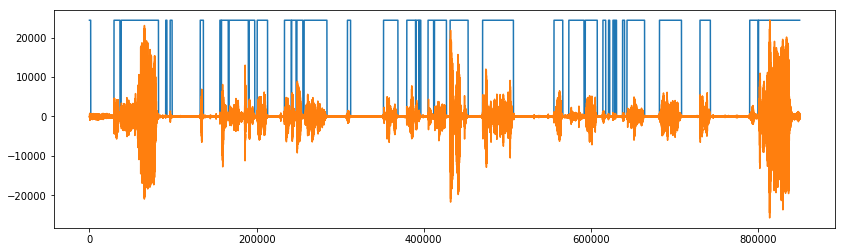

148_4_mono.wav :	 53.01 % de speech


In [10]:
import webrtcvad
import wave

w = wave.open(directory + 'corpus/audio/' + selected_wav, "rb")
binary_data = w.readframes(w.getnframes())

signal, fe = librosa.load(directory + 'corpus/audio/' + selected_wav, sr=16000, mono=True)

speech = get_speech_intervals(binary_data, fe=fe, agg=3, affichage=True)
print(selected_wav, ":\t", round(speech.sum()*100 / len(speech),2), "% de speech")

#### SNR using speech detection
bad on recomposed signal from binary

In [11]:
def get_SNR(signal, speech, fe=16000):
    s = pd.Series(signal)
    energy_total = (s**2).rolling(window=fe, min_periods=2, center=True).mean()

    energy_speech = (s[speech]**2).rolling(window=fe, min_periods=2, center=True).mean()
    energy_notSpeech = (s[~speech]**2).rolling(window=fe, min_periods=2, center=True).mean()

    SNR = energy_speech.mean() / (energy_speech.mean() + energy_notSpeech.mean())
    
    return SNR

In [12]:
signal, fe = librosa.load(directory + 'corpus/audio/' + selected_wav, sr=16000, mono=True)

w = wave.open(directory + 'corpus/audio/' + selected_wav, "rb")
binary_data = w.readframes(w.getnframes())
signal_recompose = np.frombuffer(binary_data, dtype=np.int16)

speech = get_speech_intervals(binary_data, fe=fe, agg=3)
SNR = get_SNR(signal, speech, fe=fe)

print(selected_wav, ":\t\tSNR  =", round(SNR*100,2), "%")

148_4_mono.wav :		SNR  = 99.9 %


# Tests

#### SNR (crapy for now)

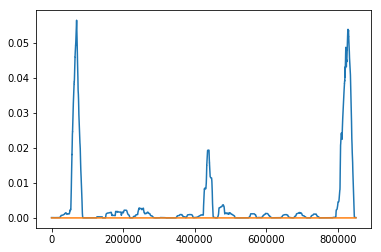

In [14]:
signal, fe = librosa.load(directory + 'corpus/audio/' + selected_wav, sr=16000, mono=True)
energy = (pd.Series(signal)**2).rolling(window=fe, min_periods=2, center=True).mean()

s = pd.Series(signal)
energy = (s**2).rolling(window=fe, min_periods=2, center=True).mean()
min_E = min(energy)
min_E = np.percentile(energy, 5)
plt.plot(energy)
f = 2
plt.plot([f * min_E] * len(energy))
plt.show()